In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

dataset_path = "dataset/colon_image_sets"
seed = 42
g = torch.Generator().manual_seed(seed)

def get_dataloaders(dataset_path, batch_size: int):

    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    data = datasets.ImageFolder(root=dataset_path, transform=transform)

    # Split dataset (80% train, 20% test)
    train_size = int(0.8 * len(data))
    test_size = len(data) - train_size
    train_dataset, test_dataset = random_split(data, [train_size, test_size], generator=g)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, generator=g)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return trainloader, testloader

trainloader, testloader = get_dataloaders(dataset_path, batch_size=32)

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  
        self.fc2 = nn.Linear(128, 1)  # One output node for binary classification
        self.sigmoid = nn.Sigmoid()  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = torch.flatten(x, 1)  # Flatten for FC layers
        x = F.relu(self.fc1(x))  # Fully Connected Layer 1
        x = self.sigmoid(self.fc2(x))  # Output Layer (Sigmoid for binary classification)
        return x

In [3]:
model = Net()
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 206049


In [6]:
import torch as torch

def train(net, trainloader, optimizer, device="cpu"):
    criterion = nn.BCELoss()
    net.to(device)
    net.train()
    running_loss = 0.0
    total = 0
    i = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Ensure correct shape
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total += labels.size(0)

        running_loss += loss.item()
        i += 1
        #if i > 100:
        #    break
    
    print(f"Loss: {running_loss/len(trainloader):.4f}")
    return running_loss / len(trainloader)


def test(net, testloader, device):
    """Validate the network on the entire test set."""
    criterion = torch.nn.BCELoss()
    correct, loss = 0, 0.0
    net.to(device)
    net.eval()
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            preds = outputs > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total

    return loss / len(testloader), accuracy

def run_centralised(
    trainloader, testloader, epochs: int, lr: float, momentum: float = 0.9
):
    """A minimal (but complete) training loop"""

    # instantiate the model
    model = Net()

    # Discover device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # define optimiser with hyperparameters supplied
    optim = torch.optim.Adam(model.parameters(), lr=0.001)

    history = {
        'train': {
            'iter': [],
            'loss': []
        },
        'test': {
            'iter': [],
            'loss': [],
            'acc': []
        }
    }

    # train for the specified number of epochs
    for e in range(epochs):
        print(f"Training epoch {e} ...")
        loss = train(model, trainloader, optim, device)
        history['train']['iter'].append(e)
        history['train']['loss'].append(loss)

        if e % 5 == 0:
            print('test')
            test_loss, test_accuracy = test(model, testloader, device)
            history['test']['iter'].append(e)
            history['test']['loss'].append(test_loss)
            history['test']['acc'].append(test_accuracy)

    return history, model

In [10]:
# Construct dataloaders
trainloader, testloader = get_dataloaders(dataset_path, batch_size=32)

# Run the centralised training
history, final_model = run_centralised(trainloader, testloader, epochs=81, lr=0.01)

Training epoch 0 ...


Loss: 0.6214
test
Training epoch 1 ...
Loss: 0.4749
Training epoch 2 ...
Loss: 0.4265
Training epoch 3 ...
Loss: 0.3845
Training epoch 4 ...
Loss: 0.3554
Training epoch 5 ...
Loss: 0.3572
test
Training epoch 6 ...
Loss: 0.3509
Training epoch 7 ...
Loss: 0.3153
Training epoch 8 ...
Loss: 0.2955
Training epoch 9 ...
Loss: 0.3099
Training epoch 10 ...
Loss: 0.2808
test
Training epoch 11 ...
Loss: 0.2433
Training epoch 12 ...
Loss: 0.2443
Training epoch 13 ...
Loss: 0.2307
Training epoch 14 ...
Loss: 0.2228
Training epoch 15 ...
Loss: 0.1989
test
Training epoch 16 ...
Loss: 0.1851
Training epoch 17 ...
Loss: 0.1719
Training epoch 18 ...
Loss: 0.1571
Training epoch 19 ...
Loss: 0.1723
Training epoch 20 ...
Loss: 0.1431
test
Training epoch 21 ...
Loss: 0.1349
Training epoch 22 ...
Loss: 0.1451
Training epoch 23 ...
Loss: 0.1562
Training epoch 24 ...
Loss: 0.1062
Training epoch 25 ...
Loss: 0.1190
test
Training epoch 26 ...
Loss: 0.1149
Training epoch 27 ...
Loss: 0.1008
Training epoch 28 ...

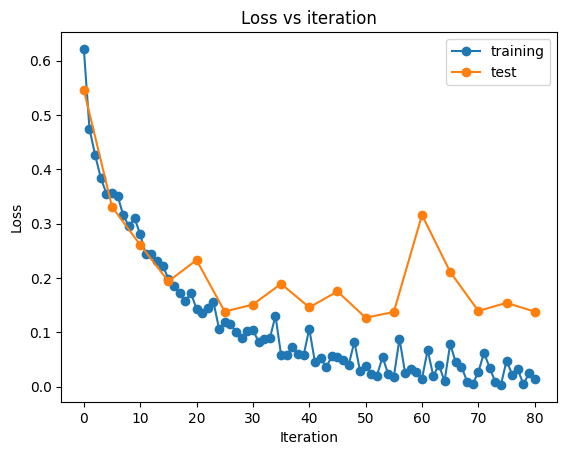

In [ ]:
import matplotlib.pyplot as plt

# Create the line plot
plt.plot(history['train']['iter'], history['train']['loss'], marker='o', label='training')
plt.plot(history['test']['iter'], history['test']['loss'], marker='o', label='test')
plt.title("Loss vs iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

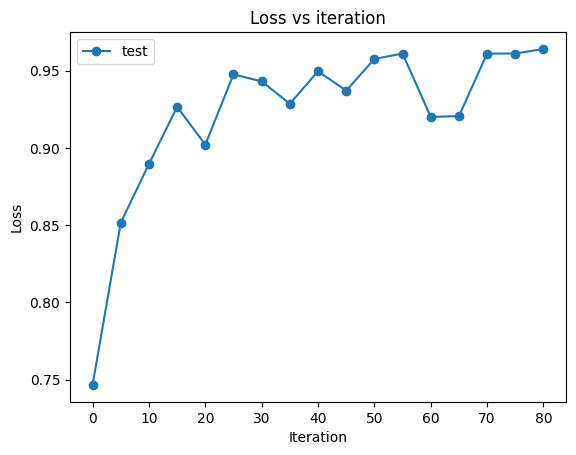

In [12]:
plt.plot(history['test']['iter'], history['test']['acc'], marker='o', label='test')
plt.title("Loss vs iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
import json

to_save = {
    'test_iter': history['test']['iter'],
    'train_iter': history['train']['iter'],
    'accuracy': history['test']['acc'], 
    'loss': history['test']['loss'],
    'train_loss': history['train']['loss'] 
}

with open('centralized.json', 'w') as f:
    json.dump(to_save, f)